In [26]:
import pandas as pd
from tqdm import tqdm
import psycopg2
import numpy as np 
import matplotlib.pyplot as plt 

main_path = "/home/fs01/spec1142/Emma/GateKeepers/"

f = open(main_path + "database.txt", "r")
user , password = f.read().split()

# Patents

## Generate embedded abstracts files by year - patents 

In [5]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [12]:
def get_patent_array(year):
    
    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password)
    
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    
    #query all abstracts of patents granted in the given year
    sql ="""SELECT ep.patent_id , ep.encoded_abstract
            FROM encoded_patents_patentsview AS ep
            JOIN patents_PatentsView AS p ON p.patent_id = ep.patent_id
            WHERE EXTRACT('year' from p.patent_date) = """ + str(year) + """ 
            AND p.patent_abstract != '';"""
    cursor.execute(sql)
    result = cursor.fetchall()

    ## print number of patents in the given year
    size = len(result)
    print("Number of patents in " + str(year) ,size)

    ## store abstracts in an array array (type: float16 to lower the file size)
    ## shape = ( size , 385 ) 
    array_abstract = np.zeros((size,384),dtype=np.float16)
    for k in tqdm(range(size)):
        try:
            array_abstract[k] = clean_encoding(result[k][1])
        except:
            continue

    ## store the patent number in another array 
    ## shape = ( size, )
    array_patents = np.array([ "US-" + elem[0] for elem in result])

    ## save files 
    np.save(main_path + 'novelty_measure/data/patents_abstracts/abstracts' + str(year) + '.npy' , array_abstract)
    np.save(main_path + 'novelty_measure/data/patents_abstracts/patents' + str(year) + '.npy' , array_patents)

    #Closing the connection
    conn.close()

In [ ]:
## parallelize the code 

import warnings   
from multiprocessing import Process

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_patent_array, args=(k,)) for k in range(1976,2024)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

## Calculate patents novelty 

In [13]:
## load array with patent abstracts 
## note that first_year and last_year are INCLUDED.

def load_arrays(first_year , last_year):
    
    array_abstract = np.concatenate([  np.load(main_path + 'novelty_measure/data/patents_abstracts/abstracts' + str(year) + '.npy') for year in range(first_year , last_year + 1)])
    array_patents = np.concatenate([  np.load(main_path + 'novelty_measure/data/patents_abstracts/patents' + str(year) + '.npy') for year in range(first_year , last_year + 1)])

    return array_abstract, array_patents

In [14]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [16]:
df = pd.DataFrame(columns = [ 'patent','novelty'] )

for year in tqdm(range(1980,2024)):
    df_new = pd.DataFrame()
    
    first_year , last_year = max(1976,year-6),year-1
    old_knowlegde, old_patents = load_arrays(first_year , last_year)
    average_knowlegde = old_knowlegde.mean(axis=0)

    first_year , last_year = year,year
    new_knowlegde, new_patents = load_arrays(first_year , last_year)
    novelty = new_knowlegde.dot(average_knowlegde)

    df_new['patent'] = new_patents
    df_new['year'] = year
    df_new['novelty'] = novelty
    df = pd.concat([df , df_new])
    
df.to_csv(main_path + 'novelty_measure/data/novelty_patents.tsv', sep = "\t")

  0%|                                                    | 0/44 [00:00<?, ?it/s]/tmp/ipykernel_57077/3775586661.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df , df_new])
100%|███████████████████████████████████████████| 44/44 [03:07<00:00,  4.26s/it]


# Papers

## Generate embedded abstracts files by year - papers 

In [32]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text
        

def get_papers_array(year):
    
    
    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password)
    
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    
    #query all abstracts of papers published in the given year
    sql ="""SELECT w.work_id , ew.encoded_abstract, w.publication_date
        FROM encoded_works_OpenAlex AS ew
        JOIN works_Openalex AS w ON w.work_id = ew.work_id
        WHERE EXTRACT('year' from w.publication_date) = """ + str(year) + """
        AND ew.encoded_abstract != '' 
        ; """

    cursor.execute(sql)
    result = cursor.fetchall()

    ## print number of patents in the given year
    size = len(result)
    print("Number of patents in " + str(year) ,size)

    ## store abstracts in an array array (type: float16 to lower the file size)
    ## shape = ( size , 385 ) 
    array_abstract = np.zeros((size,384), dtype='float16')
    for k in tqdm(range(size)):
        try:
            array_abstract[k] = clean_encoding(result[k][1])
        except:
            continue

    ## store the papers number in another array 
    ## shape = ( size, )
    array_papers = np.array([ elem[0] for elem in result])

    ## save files 
    np.save(main_path + 'novelty_measure/data/papers_abstracts/abstracts' + str(year) + '.npy' , array_abstract)
    np.save(main_path + 'novelty_measure/data/papers_abstracts/papers' + str(year) + '.npy' , array_papers)

    #Closing the connection
    conn.close()



In [ ]:
## parallelize the code 

import warnings   
from multiprocessing import Process

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_papers_array, args=(k,)) for k in range(1975,2024)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

## Calculate papers novelty

In [3]:
## load array with paper abstracts 
## note that first_year and last_year are INCLUDED.

def load_arrays(first_year , last_year):
    
    array_abstract = np.concatenate([  np.load(main_path + 'novelty_measure/data/papers_abstracts/abstracts' + str(year) + '.npy') for year in range(first_year , last_year + 1)])
    array_patents = np.concatenate([  np.load(main_path + 'novelty_measure/data/papers_abstracts/papers' + str(year) + '.npy') for year in range(first_year , last_year + 1)])

    return array_abstract, array_patents

In [4]:
## tranform string into vector
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [5]:
## calculate the novelty of the papers 

def novelty_papers(year):

    ## load abstract papers of a given year
    year_array_abstract, year_array_papers = load_arrays(year,year)

    ## load abstracts of papers published in the 5 previous years (strict 5 previous years) 
    array_abstract, array_papers = load_arrays(max(1975,year-5) , year-1)

    ## take the cosinus similarity between the papers of a given year and the average abstract of the 5 previous years. 
    old_knowledge = array_abstract.mean(axis = 0)
    novelty = year_array_abstract.dot(old_knowledge)

    ## store novelty score in a DataFrame
    df_novelty = pd.DataFrame()
    df_novelty['work_id'] = year_array_papers
    df_novelty['novelty'] = novelty

    ## store the DataFrame
    df_novelty.to_csv(main_path + '/novelty_measure/data/novelty_papers/novelty_' + str(year) + '.tsv', sep = '\t' , index = False)

In [8]:
import warnings
        
from multiprocessing import Process

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=novelty_papers, args=(year,)) for year in range(1998,1999)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

In [9]:
novelty_files = pd.concat( [ pd.read_csv(main_path + '/novelty_measure/data/novelty_papers/novelty_' + str(year) + '.tsv', delimiter = '\t') for year in range(1980,2023) ] )
novelty_files = novelty_files.drop_duplicates('work_id')

In [10]:
novelty_files.head()

,work_id,novelty
0,W220796260,0.05844
1,W166027323,0.06696
2,W2146282595,0.01184
3,W347893063,0.07530
4,W4376860334,0.05905


In [11]:
novelty_files.to_csv(main_path + '/novelty_measure/data/novelty_papers_1980_2023.tsv', sep = "\t")

# Novelty distributions

## Patents

In [12]:
novelty_patents = pd.read_csv(main_path + 'novelty_measure/data/novelty_patents.tsv', sep = "\t")

Text(0.5, 0, "patent's novelty")

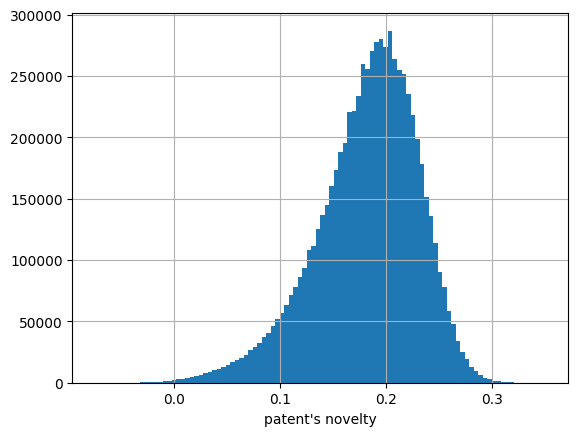

In [28]:
novelty_patents[novelty_patents['novelty'] != 0]['novelty'].hist(bins=100)
plt.xlabel("patent's novelty")

## Papers

In [ ]:
novelty_papers - pd.read_csv(main_path + '/novelty_measure/data/novelty_papers_1980_2023.tsv', delimiter = "\t", index_col = 0 )

Text(0.5, 0, "paper's novelty")

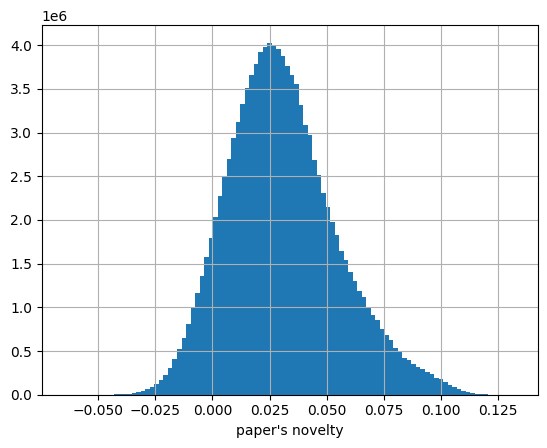

In [27]:
novelty_papers['novelty'].hist(bins=100)
plt.xlabel("paper's novelty")